In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler,OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report,roc_auc_score,confusion_matrix
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier

In [2]:
df = pd.read_csv("customer_churn_cleaned.csv")

In [3]:
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [4]:
df.tail()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
7038,6840-RESVB,Male,0,Yes,Yes,24,Yes,Yes,DSL,Yes,...,Yes,Yes,Yes,Yes,One year,Yes,Mailed check,84.80,1990.50,No
7039,2234-XADUH,Female,0,Yes,Yes,72,Yes,Yes,Fiber optic,No,...,Yes,No,Yes,Yes,One year,Yes,Credit card (automatic),103.20,7362.90,No
7040,4801-JZAZL,Female,0,Yes,Yes,11,No,No phone service,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.60,346.45,No
7041,8361-LTMKD,Male,1,Yes,No,4,Yes,Yes,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Mailed check,74.40,306.60,Yes
7042,3186-AJIEK,Male,0,No,No,66,Yes,No,Fiber optic,Yes,...,Yes,Yes,Yes,Yes,Two year,Yes,Bank transfer (automatic),105.65,6844.50,No


In [5]:
df.shape

(7043, 21)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [7]:
df.describe()


,SeniorCitizen,tenure,MonthlyCharges,TotalCharges
count,7043.000000,7043.000000,7043.000000,7043.000000
mean,0.162147,32.371149,64.761692,2281.916928
std,0.368612,24.559481,30.090047,2265.270398
min,0.000000,0.000000,18.250000,18.800000
25%,0.000000,9.000000,35.500000,402.225000
50%,0.000000,29.000000,70.350000,1397.475000
75%,0.000000,55.000000,89.850000,3786.600000
max,1.000000,72.000000,118.750000,8684.800000


In [8]:
df['tenure_group'] = pd.cut(
    df['tenure'],
    bins=[0, 6, 12, 24, 72],
    labels=['0-6', '6-12', '12-24', '24+']
)


In [9]:
df['avg_monthly_spend'] = df['TotalCharges'] / df['tenure']
df['avg_monthly_spend'] = df['avg_monthly_spend'].fillna(0)


In [10]:
services = [
    'PhoneService', 'InternetService', 'OnlineSecurity',
    'OnlineBackup', 'DeviceProtection', 'TechSupport',
    'StreamingTV', 'StreamingMovies'
]

df['num_services_used'] = df[services].apply(
    lambda x: (x == 'Yes').sum(),
    axis=1
)


In [11]:
df['auto_payment_flag'] = df['PaymentMethod'].apply(
    lambda x: 1 if 'automatic' in x.lower() else 0
)


In [12]:
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,tenure_group,avg_monthly_spend,num_services_used,auto_payment_flag
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,Month-to-month,Yes,Electronic check,29.85,29.85,No,0-6,29.850000,1,0
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,One year,No,Mailed check,56.95,1889.50,No,24+,55.573529,3,0
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,Month-to-month,Yes,Mailed check,53.85,108.15,Yes,0-6,54.075000,3,0
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,One year,No,Bank transfer (automatic),42.30,1840.75,No,24+,40.905556,3,1
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,Month-to-month,Yes,Electronic check,70.70,151.65,Yes,0-6,75.825000,1,0


In [13]:
X = df.drop(columns=["customerID", "Churn"])
y = df["Churn"]


In [14]:
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

for train_idx, test_idx in sss.split(X, y):
    Churn_train, Churn_test = X.iloc[train_idx], X.iloc[test_idx]
    Churn1_train, Churn1_test = y.iloc[train_idx], y.iloc[test_idx]


In [15]:
print(y.value_counts(normalize=True))
print(Churn_train.value_counts(normalize=True))
print(Churn_test.value_counts(normalize=True))


Churn
No     0.73463
Yes    0.26537
Name: proportion, dtype: float64
gender  SeniorCitizen  Partner  Dependents  tenure  PhoneService  MultipleLines  InternetService  OnlineSecurity       OnlineBackup         DeviceProtection     TechSupport          StreamingTV          StreamingMovies      Contract        PaperlessBilling  PaymentMethod            MonthlyCharges  TotalCharges  tenure_group  avg_monthly_spend  num_services_used  auto_payment_flag
Male    0              No       No          1       Yes           No             No               No internet service  No internet service  No internet service  No internet service  No internet service  No internet service  Month-to-month  No                Mailed check             20.20           20.20         0-6           20.200000          1                  0                    0.000711
Female  0              No       No          1       Yes           No             No               No internet service  No internet service  No internet s

In [16]:
num_cols = ['tenure', 'MonthlyCharges', 'TotalCharges']
cat_cols = ['Contract', 'PaymentMethod', 'InternetService','tenure_group']


In [17]:
num_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
])


In [18]:
cat_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder",OneHotEncoder(handle_unknown="ignore"))
])


In [19]:
preprocessor = ColumnTransformer([
    ("num", num_pipeline, num_cols),
    ("cat", cat_pipeline, cat_cols)
    
])

In [20]:
churn_prepared = preprocessor.fit_transform(Churn_train)

In [21]:
print(churn_prepared)

[[ 0.10237124 -0.52197565 -0.26328906 ...  0.          1.
   0.        ]
 [-0.71174346  0.33747781 -0.50481448 ...  1.          0.
   0.        ]
 [-0.79315493 -0.80901319 -0.75121344 ...  1.          0.
   0.        ]
 ...
 [-0.30468611  1.25666162  0.15756931 ...  0.          1.
   0.        ]
 [-0.34539184 -1.47766135 -0.79843405 ...  1.          0.
   0.        ]
 [-1.07809507 -1.46936546 -0.96242195 ...  0.          0.
   0.        ]]


In [45]:
y_true = Churn1_test.map({"No": 0, "Yes": 1})


# Logistic Regression

In [22]:
model = LogisticRegression(
    max_iter=1000,
    class_weight="balanced"
)
model.fit(churn_prepared,Churn1_train)

,"penalty penalty: {'l1', 'l2', 'elasticnet', None}, default='l2'Specify the norm of the penalty:- `None`: no penalty is added;- `'l2'`: add a L2 penalty term and it is the default choice;- `'l1'`: add a L1 penalty term;- `'elasticnet'`: both L1 and L2 penalty terms are added... warning:: Some penalties may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionadded:: 0.19 l1 penalty with SAGA solver (allowing 'multinomial' + L1).. deprecated:: 1.8 `penalty` was deprecated in version 1.8 and will be removed in 1.10. Use `l1_ratio` instead. `l1_ratio=0` for `penalty='l2'`, `l1_ratio=1` for `penalty='l1'` and `l1_ratio` set to any float between 0 and 1 for `'penalty='elasticnet'`.",'deprecated'
,"C C: float, default=1.0Inverse of regularization strength; must be a positive float.Like in support vector machines, smaller values specify strongerregularization. `C=np.inf` results in unpenalized logistic regression.For a visual example on the effect of tuning the `C` parameterwith an L1 penalty, see::ref:`sphx_glr_auto_examples_linear_model_plot_logistic_path.py`.",1.0
,"l1_ratio l1_ratio: float, default=0.0The Elastic-Net mixing parameter, with `0 <= l1_ratio <= 1`. Setting`l1_ratio=1` gives a pure L1-penalty, setting `l1_ratio=0` a pure L2-penalty.Any value between 0 and 1 gives an Elastic-Net penalty of the form`l1_ratio * L1 + (1 - l1_ratio) * L2`... warning:: Certain values of `l1_ratio`, i.e. some penalties, may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionchanged:: 1.8 Default value changed from None to 0.0... deprecated:: 1.8 `None` is deprecated and will be removed in version 1.10. Always use `l1_ratio` to specify the penalty type.",0.0
,"dual dual: bool, default=FalseDual (constrained) or primal (regularized, see also:ref:`this equation `) formulation. Dual formulationis only implemented for l2 penalty with liblinear solver. Prefer `dual=False`when n_samples > n_features.",False
,"tol tol: float, default=1e-4Tolerance for stopping criteria.",0.0001
,"fit_intercept fit_intercept: bool, default=TrueSpecifies if a constant (a.k.a. bias or intercept) should beadded to the decision function.",True
,"intercept_scaling intercept_scaling: float, default=1Useful only when the solver `liblinear` is usedand `self.fit_intercept` is set to `True`. In this case, `x` becomes`[x, self.intercept_scaling]`,i.e. a ""synthetic"" feature with constant value equal to`intercept_scaling` is appended to the instance vector.The intercept becomes``intercept_scaling * synthetic_feature_weight``... note:: The synthetic feature weight is subject to L1 or L2 regularization as all other features. To lessen the effect of regularization on synthetic feature weight (and therefore on the intercept) `intercept_scaling` has to be increased.",1
,"class_weight class_weight: dict or 'balanced', default=NoneWeights associated with classes in the form ``{class_label: weight}``.If not given, all classes are supposed to have weight one.The ""balanced"" mode uses the values of y to automatically adjustweights inversely proportional to class frequencies in the input dataas ``n_samples / (n_classes * np.bincount(y))``.Note that these weights will be multiplied with sample_weight (passedthrough the fit method) if sample_weight is specified... versionadded:: 0.17 *class_weight='balanced'*",'balanced'
,"random_state random_state: int, RandomState instance, default=NoneUsed when ``solver`` == 'sag', 'saga' or 'liblinear' to shuffle thedata. See :term:`Glossary ` for details.",None
,"solver solver: {'lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'}, default='lbfgs'Algorithm to use in the optimization problem. Default is 'lbfgs'.To choose a solver, you might want to consider the following aspects:- 'lbfgs' is a good default solver because it works reasonably well for a wide class of problems.- For :ter

In [23]:
Churn_test_prepared = preprocessor.transform(Churn_test)


In [24]:
Churn_prediction_lg = model.predict(Churn_test_prepared)


In [25]:
Churn_prediction_lg

array(['No', 'Yes', 'No', ..., 'No', 'No', 'No'], dtype=object)

In [44]:
model.classes_


array(['No', 'Yes'], dtype=object)

In [46]:
lg_probs = model.predict_proba(Churn_test_prepared)[:, 1]

roc_auc_lg = roc_auc_score(y_true, lg_probs)
roc_auc_lg


0.8390245162623677

In [51]:
cm_lg = confusion_matrix(Churn1_test, Churn_prediction_lg)
cm_lg

array([[756, 279],
       [ 83, 291]], dtype=int64)

In [28]:
print(classification_report(Churn1_test, Churn_prediction_lg))


              precision    recall  f1-score   support

          No       0.90      0.73      0.81      1035
         Yes       0.51      0.78      0.62       374

    accuracy                           0.74      1409
   macro avg       0.71      0.75      0.71      1409
weighted avg       0.80      0.74      0.76      1409



# GradientBoosting Classifier

In [29]:
gb = GradientBoostingClassifier(random_state=42)
smote = SMOTE(random_state=42)
Churn_train_gbs,Churn1_train_gbs= smote.fit_resample(churn_prepared,Churn1_train)
gb.fit(Churn_train_gbs, Churn1_train_gbs)

,"loss loss: {'log_loss', 'exponential'}, default='log_loss'The loss function to be optimized. 'log_loss' refers to binomial andmultinomial deviance, the same as used in logistic regression.It is a good choice for classification with probabilistic outputs.For loss 'exponential', gradient boosting recovers the AdaBoost algorithm.",'log_loss'
,"learning_rate learning_rate: float, default=0.1Learning rate shrinks the contribution of each tree by `learning_rate`.There is a trade-off between learning_rate and n_estimators.Values must be in the range `[0.0, inf)`.For an example of the effects of this parameter and its interaction with``subsample``, see:ref:`sphx_glr_auto_examples_ensemble_plot_gradient_boosting_regularization.py`.",0.1
,"n_estimators n_estimators: int, default=100The number of boosting stages to perform. Gradient boostingis fairly robust to over-fitting so a large number usuallyresults in better performance.Values must be in the range `[1, inf)`.",100
,"subsample subsample: float, default=1.0The fraction of samples to be used for fitting the individual baselearners. If smaller than 1.0 this results in Stochastic GradientBoosting. `subsample` interacts with the parameter `n_estimators`.Choosing `subsample < 1.0` leads to a reduction of varianceand an increase in bias.Values must be in the range `(0.0, 1.0]`.",1.0
,"criterion criterion: {'friedman_mse', 'squared_error'}, default='friedman_mse'The function to measure the quality of a split. Supported criteria are'friedman_mse' for the mean squared error with improvement score byFriedman, 'squared_error' for mean squared error. The default value of'friedman_mse' is generally the best as it can provide a betterapproximation in some cases... versionadded:: 0.18",'friedman_mse'
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, values must be in the range `[2, inf)`.- If float, values must be in the range `(0.0, 1.0]` and `min_samples_split` will be `ceil(min_samples_split * n_samples)`... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, values must be in the range `[1, inf)`.- If float, values must be in the range `(0.0, 1.0)` and `min_samples_leaf` will be `ceil(min_samples_leaf * n_samples)`... versionchanged:: 0.18 Added float values for fractions.",1
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.Values must be in the range `[0.0, 0.5]`.",0.0
,"max_depth max_depth: int or None, default=3Maximum depth of the individual regression estimators. The maximumdepth limits the number of nodes in the tree. Tune this parameterfor best performance; the best value depends on the interactionof the input variables. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.If int, values must be in the range `[1, inf)`.",3
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.Values must be in the range `[0.0, inf)`.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsamples at the current node, ``N_t_L`` is the number of samples in theleft child, and ``N_t_R`` is the number of samples in the right child.``N``, ``N_t``, 

In [30]:
gb_preds = gb.predict(Churn_test_prepared)

In [31]:
gb_preds

array(['No', 'Yes', 'No', ..., 'No', 'No', 'No'], dtype=object)

In [52]:
from sklearn.metrics import confusion_matrix  # re-imported due to overwritten issue
cm_gb = confusion_matrix(Churn1_test, gb_preds)
cm_gb

array([[764, 271],
       [ 75, 299]], dtype=int64)

In [33]:
print(classification_report(Churn1_test,gb_preds))

              precision    recall  f1-score   support

          No       0.91      0.74      0.82      1035
         Yes       0.52      0.80      0.63       374

    accuracy                           0.75      1409
   macro avg       0.72      0.77      0.72      1409
weighted avg       0.81      0.75      0.77      1409



In [47]:
gb_probs = gb.predict_proba(Churn_test_prepared)[:, 1]
roc_auc_gb = roc_auc_score(y_true, gb_probs)
roc_auc_gb

0.8385000904182489

# Random Forest Classifier

In [34]:
rf = RandomForestClassifier(
    n_estimators=300,
    random_state=42,
    class_weight="balanced",
    n_jobs=-1
)

rf.fit(churn_prepared, Churn1_train)

,"n_estimators n_estimators: int, default=100The number of trees in the forest... versionchanged:: 0.22 The default value of ``n_estimators`` changed from 10 to 100 in 0.22.",300
,"criterion criterion: {""gini"", ""entropy"", ""log_loss""}, default=""gini""The function to measure the quality of a split. Supported criteria are""gini"" for the Gini impurity and ""log_loss"" and ""entropy"" both for theShannon information gain, see :ref:`tree_mathematical_formulation`.Note: This parameter is tree-specific.",'gini'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",None
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",1
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: {""sqrt"", ""log2"", None}, int or float, default=""sqrt""The number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None, then `max_features=n_features`... versionchanged:: 1.1 The default of `max_features` changed from `""auto""` to `""sqrt""`.Note: the search for a split does not stop until at least onevalid partition of the node samples is found, even if it requires toeffectively inspect more than ``max_features`` features.",'sqrt'
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow trees with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",None
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsamples at the current node, ``N_t_L`` is the number of samples in theleft child, and ``N_t_R`` is the number of samples in the right child.``N``, ``N_t``, ``N_t_R`` and ``N_t_L`` all refer to the weighted sum,if ``sample_weight`` is passed... versionadded:: 0.19",0.0
,"bootstrap bootstrap: bool, default=TrueWhether bootstrap samples are used when building trees. If False, thewhole dataset is used to build each tree.",True
,"oob_score oob_score: bool or callable, default=FalseWhether to use out-of-bag samples to estimate the generalization score.By default, :func:`~sklearn.metrics.accuracy_score` is used.Provide a callable with signature `metric

In [35]:
rf_prediction = rf.predict(Churn_test_prepared)

In [36]:
rf_prediction

array(['No', 'Yes', 'No', ..., 'No', 'No', 'No'], dtype=object)

In [50]:
from sklearn.metrics import confusion_matrix  # re-imported due to overwritten issue
cm_rf = confusion_matrix(Churn1_test, rf_prediction)
cm_rf

array([[895, 140],
       [188, 186]], dtype=int64)

In [38]:
print(classification_report(Churn1_test,rf_prediction))

              precision    recall  f1-score   support

          No       0.83      0.86      0.85      1035
         Yes       0.57      0.50      0.53       374

    accuracy                           0.77      1409
   macro avg       0.70      0.68      0.69      1409
weighted avg       0.76      0.77      0.76      1409



In [40]:
# need to do roc_auc!!!

In [48]:
rf_probs = rf.predict_proba(Churn_test_prepared)[:, 1]

roc_auc_rf = roc_auc_score(y_true, rf_probs)
roc_auc_rf


0.8057854762458344

In [49]:
# since the recall of GradientBoosting Classifier is higher than other model we select the GradientBoosting Classifier


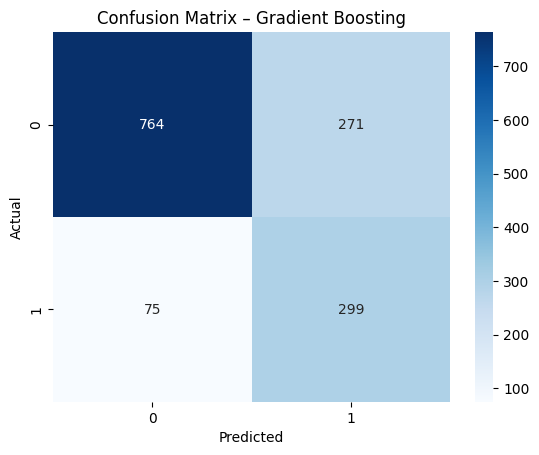

In [53]:
sns.heatmap(cm_gb, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix – Gradient Boosting")
plt.show()